In [1]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pylab as plt
from skimpy import skim
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns

from tqdm import tqdm



In [2]:

import tensorflow as tf
import tensorflow_probability as tfp

from bayesianquilts.models.logistic_regression import LogisticRegression
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2024-01-27 03:18:09.751111: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 03:18:09.776614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 03:18:09.776641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 03:18:09.777750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-27 03:18:09.782688: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 03:18:09.783178: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
print(tf.__version__, tfp.__version__)

2.15.0 0.23.0


# Load the dataset

Using the example from here: https://www.tensorflow.org/guide/core/logistic_regression_core

In [4]:
from ucimlrepo import fetch_ucirepo 


In [5]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  

In [29]:

# data (as pandas dataframes) 
batch_size=151
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

X = X.fillna(0)

In [30]:
X = X[:batch_size*10]
y = y[:batch_size*10]

In [31]:
new_features = []
for ik, k in tqdm(enumerate(X.columns)):
    for ij, j in enumerate(X.columns):
        for ii, i in enumerate(X.columns):
            if ij<ik or ii < ij:
                continue
            new_features += [X[k]*X[j]*X[i]]

        

21it [00:00, 37.02it/s]


In [32]:
X = pd.concat([X] + new_features, axis=1)

In [40]:
X_scaled = (X - X.min())/X.max()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))

(1510, 1792)


Instantiate the model object

In [41]:
lr_model = LogisticRegression(dim_regressors=p)

Set up Bayesian minibatch ADVI inference

In [42]:


tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y})

def data_factory():
    out = tfdata.shuffle(batch_size*10).batch(batch_size)
    return out

In [43]:
losses = lr_model.fit(
    data_factory,
    dataset_size=n,
    batches_per_step=1,
    check_every=int(n/batch_size),
    batch_size=batch_size,
    num_steps=300,
    max_decay_steps=100,
    max_plateau_epochs=100,
    sample_size=32,
    learning_rate=0.0005)

Running optimization for 300 steps of 1 accumulated batches, checking every 10 steps
Saved a checkpoint: /tmp/tfcheckpoints/d3dec167-2ea3-4e7b-b335-21e27b9191aa/d3dec167-2ea3-4e7b-b335-21e27b9191aa-1


  0%|          | 0/300 [00:00<?, ?it/s]

  2%|▏         | 7/300 [00:01<00:35,  8.35it/s]

Step 10: average-batch loss:174.7072845139437 rel loss: 5.723859785137855e+305
Saved a checkpoint: /tmp/tfcheckpoints/d3dec167-2ea3-4e7b-b335-21e27b9191aa/d3dec167-2ea3-4e7b-b335-21e27b9191aa-2


  6%|▋         | 19/300 [00:01<00:15, 18.23it/s]

Step 20: average-batch loss:175.237223895091 rel loss: 0.0030241256359126016
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


  9%|▉         | 28/300 [00:02<00:12, 21.54it/s]

Step 30: average-batch loss:177.52567319203922 rel loss: 0.015875949812885436
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 12%|█▏        | 37/300 [00:02<00:11, 22.75it/s]

Step 40: average-batch loss:173.31607607430396 rel loss: 0.008027001713581967
Saved a checkpoint: /tmp/tfcheckpoints/d3dec167-2ea3-4e7b-b335-21e27b9191aa/d3dec167-2ea3-4e7b-b335-21e27b9191aa-3


 16%|█▋        | 49/300 [00:03<00:10, 22.85it/s]

Step 50: average-batch loss:176.4377428993388 rel loss: 0.017692738377501203
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 19%|█▉        | 58/300 [00:03<00:10, 23.01it/s]

Step 60: average-batch loss:176.24084632773264 rel loss: 0.016595303043369716
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 22%|██▏       | 67/300 [00:03<00:10, 23.21it/s]

Step 70: average-batch loss:186.07760940636803 rel loss: 0.06858177817726914
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 26%|██▋       | 79/300 [00:04<00:09, 23.29it/s]

Step 80: average-batch loss:181.8410029115622 rel loss: 0.04688121326191937
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 29%|██▉       | 88/300 [00:04<00:09, 23.42it/s]

Step 90: average-batch loss:192.33933763055396 rel loss: 0.098904684764954
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 32%|███▏      | 97/300 [00:05<00:08, 23.24it/s]

Step 100: average-batch loss:190.69417157775723 rel loss: 0.09113071133570118
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 36%|███▋      | 109/300 [00:05<00:08, 23.39it/s]

Step 110: average-batch loss:181.6832472425207 rel loss: 0.046053619666142284
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 39%|███▉      | 118/300 [00:05<00:07, 23.31it/s]

Step 120: average-batch loss:189.37130905418633 rel loss: 0.08478176055322272
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 42%|████▏     | 127/300 [00:06<00:07, 23.34it/s]

Step 130: average-batch loss:185.44943265712715 rel loss: 0.06542676571707957
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 46%|████▋     | 139/300 [00:06<00:06, 23.17it/s]

Step 140: average-batch loss:188.3568168358142 rel loss: 0.07985238343999437
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 49%|████▉     | 148/300 [00:07<00:06, 23.34it/s]

Step 150: average-batch loss:183.10775698197642 rel loss: 0.053474965064621856
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 52%|█████▏    | 157/300 [00:07<00:06, 23.53it/s]

Step 160: average-batch loss:181.95485724649262 rel loss: 0.04747760682467398
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 56%|█████▋    | 169/300 [00:08<00:05, 23.47it/s]

Step 170: average-batch loss:193.93639549222155 rel loss: 0.10632516586472615
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 59%|█████▉    | 178/300 [00:08<00:05, 23.24it/s]

Step 180: average-batch loss:187.74728150559656 rel loss: 0.0768650566632168
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 62%|██████▏   | 187/300 [00:08<00:04, 23.32it/s]

Step 190: average-batch loss:184.10196550961894 rel loss: 0.0585864980064617
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 66%|██████▋   | 199/300 [00:09<00:04, 23.18it/s]

Step 200: average-batch loss:191.31647050126992 rel loss: 0.09408700871285659
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 69%|██████▉   | 208/300 [00:09<00:03, 23.34it/s]

Step 210: average-batch loss:192.22633587902618 rel loss: 0.09837496885246261
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 72%|███████▏  | 217/300 [00:10<00:03, 23.49it/s]

Step 220: average-batch loss:186.38613393130794 rel loss: 0.07012355254828616
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 76%|███████▋  | 229/300 [00:10<00:03, 23.32it/s]

Step 230: average-batch loss:199.19894641457336 rel loss: 0.12993477528943298
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 79%|███████▉  | 238/300 [00:11<00:02, 23.32it/s]

Step 240: average-batch loss:183.24567181100025 rel loss: 0.054187341171897795
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 82%|████████▏ | 247/300 [00:11<00:02, 23.24it/s]

Step 250: average-batch loss:189.84570031996515 rel loss: 0.08706873117380179
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 86%|████████▋ | 259/300 [00:12<00:01, 23.36it/s]

Step 260: average-batch loss:192.71741977728186 rel loss: 0.10067249616251342
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 89%|████████▉ | 268/300 [00:12<00:01, 23.33it/s]

Step 270: average-batch loss:193.11546040325925 rel loss: 0.10252614828253868
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 92%|█████████▏| 277/300 [00:12<00:00, 23.34it/s]

Step 280: average-batch loss:188.77417226988615 rel loss: 0.08188671156498092
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 96%|█████████▋| 289/300 [00:13<00:00, 23.26it/s]

Step 290: average-batch loss:200.10734174448248 rel loss: 0.13388447138730344
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


 99%|█████████▉| 298/300 [00:13<00:00, 23.14it/s]

Step 300: average-batch loss:197.32164183901813 rel loss: 0.12165703437790538
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>
We are in a loss plateau
Restoring from a checkpoint


Terminating because we are out of iterations


100%|██████████| 300/300 [00:13<00:00, 21.75it/s]


In [44]:
test_batch = next(iter(data_factory()))
param_test = lr_model.sample(32)


In [46]:
def adaptive_is_loo(self, data, params, h):
    """Compute step-away transformation for LOO
    Keyword arguments:
    argument -- description
    Return: return_description
    """
    
    y = tf.cast(tf.squeeze(data['y']), tf.float64)
    X = tf.cast(data['X'], tf.float64)
    mu = tf.reduce_sum(params['beta__']*data['X'], axis=-1) + params['intercept__'][..., 0]
    sigma = tf.math.sigmoid(mu)
    
    # Standard LOO
    
    ell = (y*(sigma)+(1-y)*(1-sigma))
    nu_weights = 1/ell
    nu_weights = nu_weights/tf.reduce_sum(nu_weights, axis=0, keepdims=True)
    p_loo = tf.reduce_sum(sigma*nu_weights, axis=0)
    p_loo_sd = tf.math.reduce_std(sigma*nu_weights, axis=0)
    ll_loo = tf.reduce_sum(nu_weights*ell, axis=0)
    ll_loo_sd = tf.math.reduce_std(nu_weights*ell, axis=0)
    # Common
    
    log_ell_prime = tf.cast(y, tf.float64)*tf.cast(1-sigma, tf.float64)-tf.cast(1-y, tf.float64)*tf.cast(sigma, tf.float64)
    log_ell_doubleprime = -tf.cast(1-sigma, tf.float64)*tf.cast(sigma, tf.float64)
    
    log_pi_beta0 = self.surrogate_distribution.model['beta__'].log_prob( self.surrogate_distribution.model['beta__'].mean())
    log_pi_beta = self.surrogate_distribution.model['beta__'].log_prob(params['beta__']) - log_pi_beta0
    log_pi_intercept0 = self.surrogate_distribution.model['intercept__'].log_prob( self.surrogate_distribution.model['intercept__'].mean())
    log_pi_intercept= self.surrogate_distribution.model['intercept__'].log_prob(params['intercept__']) - log_pi_intercept0
    log_pi = log_pi_beta + log_pi_intercept
    
    # scaled (theta - bar(theta))/Sigma
    delta_beta = params['beta__'] - self.surrogate_distribution.model['beta__'].mean()
    delta_beta = delta_beta/self.surrogate_distribution.model['beta__'].variance()
    delta_intercept = params['intercept__'] - self.surrogate_distribution.model['intercept__'].mean()
    delta_intercept = delta_intercept/self.surrogate_distribution.model['intercept__'].variance()
    
    # log-likelihood descent
    
    def T_I(beta, intercept):
        return beta, intercept
    
    def J_I(sigma):
        return 1.

    
    def J_ll(sigma):
        return 1 + h*(1 + tf.math.reduce_sum(X*X, -1))*sigma*(1-sigma)
    
    def T_ll(beta, intercept):
        beta_ll = beta - h*log_ell_prime[..., tf.newaxis] * data['X']
        intercept_ll = intercept - h*log_ell_prime[..., tf.newaxis]
        return beta_ll, intercept_ll

    def T_kl(beta, intercept):
        beta_step = -tf.math.exp(log_pi)[..., tf.newaxis, tf.newaxis]*log_ell_prime[..., tf.newaxis] * data['X']/ell[..., tf.newaxis]
        beta_kl = beta + h*beta_step
        intercept_step = -tf.math.exp(log_pi)[..., tf.newaxis, tf.newaxis]*log_ell_prime[..., tf.newaxis]/ell[..., tf.newaxis]
        intercept_kl = intercept + h*intercept_step
        return beta_kl, intercept_kl
    
    def J_kl(sigma):
        dQ = tf.math.exp(log_pi)[..., tf.newaxis]/ell * (
            (log_ell_prime**2 - log_ell_doubleprime)*(1 + tf.math.reduce_sum(X*X, -1)) + log_ell_prime*(delta_intercept[:, :, 0] + tf.reduce_sum(delta_beta*X, axis=-1, keepdims=False))
            )
        return 1 + h*dQ

    # variance descent -(log ell)'/l
    
    def T_var(beta, intercept):
        # S x N x P
        intercept_step = tf.math.exp(log_pi[..., tf.newaxis, tf.newaxis])*(
            (sigma/ell)**2*( 1 - sigma - log_ell_prime)
        )[..., tf.newaxis]
        beta_step = intercept_step * data['X']

        return beta + h*beta_step, intercept + h*intercept_step
    
    def J_var(sigma):
        dQ = 0
        return 1 + h*dQ
    
    def IS(beta, intercept, Q, jacobian):
        beta_new, intercept_new = Q(beta, intercept)
        mu_new= tf.reduce_sum(beta_new*data['X'], axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        
        ell_new = (y*(sigma_new)+(1-y)*(1-sigma_new))
        J = jacobian(sigma)
        log_beta_new = self.surrogate_distribution.model['beta__'].log_prob(beta_new[..., tf.newaxis, :]) - log_pi_beta0
        log_intercept_new = self.surrogate_distribution.model['intercept__'].log_prob(intercept_new[..., tf.newaxis, :]) - log_pi_intercept0

        eta_weights = J*tf.math.exp(log_beta_new + log_intercept_new - log_pi_beta[:, tf.newaxis] - log_pi_intercept[:, tf.newaxis])/ell_new
        
        psis_weights, khat = nppsis.psislw( tf.math.log(eta_weights))
        
        eta_weights = eta_weights/tf.reduce_sum(eta_weights, axis=0, keepdims=True)
        
        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights/tf.math.reduce_sum(psis_weights, axis=0, keepdims=True)
        
        weight_entropy = tf.reduce_sum(-eta_weights * tf.math.log(eta_weights), axis=0)
        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights*ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights*ell_new, axis=0)
        return eta_weights, p_loo_new, p_loo_sd, ll_loo_new, ll_loo_sd, weight_entropy, khat
    
    eta_I, p_loo_I, p_loo_I_sd, ll_loo_I, ll_loo_I_sd, S_I, k_I = IS(params['beta__'], params['intercept__'], T_I, J_I)
    
    eta_ll, p_loo_ll, p_loo_ll_sd, ll_loo_ll, ll_loo_ll_sd, S_ll, k_ll = IS(params['beta__'], params['intercept__'], T_ll, J_ll)
    # kl descent
    eta_kl, p_loo_kl, p_loo_kl_sd, ll_loo_kl, ll_loo_kl_sd, S_kl, k_kl = IS(params['beta__'], params['intercept__'], T_kl, J_kl)
    eta_var, p_loo_var, p_loo_var_sd, ll_loo_var, ll_loo_var_sd, S_var, k_var = IS(params['beta__'], params['intercept__'], T_var, J_var)

    return {
        "I": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I
        },
        "KL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_kl,
            "khat": k_kl
        },
        "LL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_ll,
            "khat": k_ll
        },
        "Var": {
            "p_loo": p_loo_var,
            "p_loo_sd": p_loo_var_sd,
            "ll_loo": ll_loo_var,
            "ll_loo_sd": ll_loo_var_sd,
            "S": S_var,
            "khat": k_var
        },
        'sigma': sigma,
    }
    
_ = adaptive_is_loo(lr_model, test_batch, param_test, 1e-2)

for T in ["I", "LL", "KL", "Var"]:
    print(f"{T}: {np.sqrt(np.mean(_[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.mean(_[T]['S']))}")

I: 0.0010332466599842745 entropy: 1.8612059170646829
LL: 0.0010332466599842745 entropy: 0.9030153148420081
KL: 0.0010332466599842745 entropy: 1.8612059170646829
Var: 0.0010332466599842745 entropy: 1.8612059170646829


# Compute LOO AU ROC/PRC

In [47]:
step_size = 1/253680
def prediction_fn_stepaway(data):
    params = lr_model.sample(100)
    loo = adaptive_is_loo(lr_model, data, params, step_size)
    return loo["LL"]['p_loo']

def prediction_fn_loo(data):
    params = lr_model.sample(100)
    pred = adaptive_is_loo(lr_model, data, params, step_size)["I"]['p_loo']
    return pred

def prediction_fn(data):
    params = lr_model.sample(100)
    pred = adaptive_is_loo(lr_model, data, params, step_size)["KL"]['p_loo']
    return pred

In [48]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory,
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory,
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)

bench = classification_metrics(
    data_factory=data_factory,
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

Step-away LOO

(0.0, 1.0)

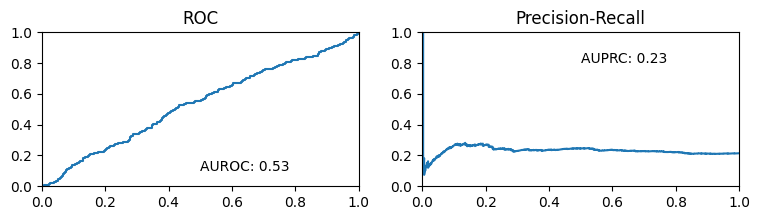

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_stepaway_loo['auroc']['fpr'], bench_stepaway_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_stepaway_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_stepaway_loo['auprc']['recall'], bench_stepaway_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_stepaway_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

LOO w/o stepaway

(0.0, 1.0)

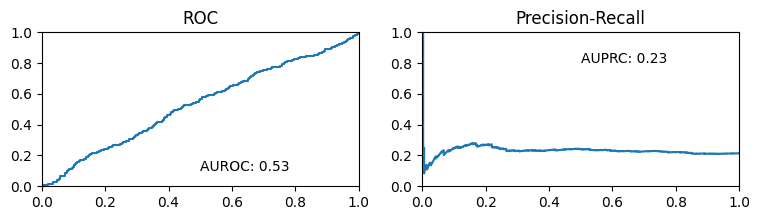

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

Training data metrics

(0.0, 1.0)

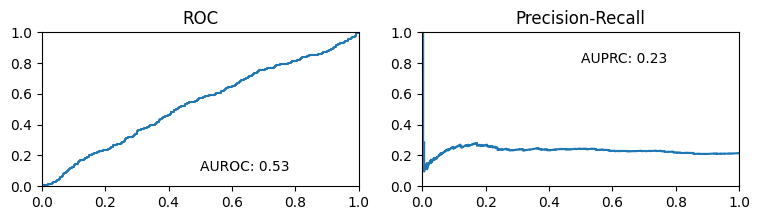

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [52]:
bench['auroc']['auroc']

0.5336513438677576

In [53]:
params = lr_model.sample(1024)
loo_out = []
for batch in tqdm(iter(data_factory())):
    loo_out += [adaptive_is_loo(lr_model, batch, params, 1/n)]

0it [00:00, ?it/s]

10it [01:19,  7.93s/it]


In [54]:
loo_out[0].keys()

dict_keys(['I', 'KL', 'LL', 'Var', 'sigma'])

In [55]:
khat = {}
for method in ["I", "LL", "KL", "Var"]:
    khat[method] = np.concatenate([out[method]["khat"] for out in loo_out], axis=0)

In [56]:
np.sum(khat["I"]>0.5)

0

(array([  4.,   8.,  24.,  96., 288., 441., 412., 191.,  40.,   6.]),
 array([-0.42989443, -0.3614606 , -0.29302678, -0.22459295, -0.15615912,
        -0.0877253 , -0.01929147,  0.04914235,  0.11757618,  0.18601001,
         0.25444383]),
 <BarContainer object of 10 artists>)

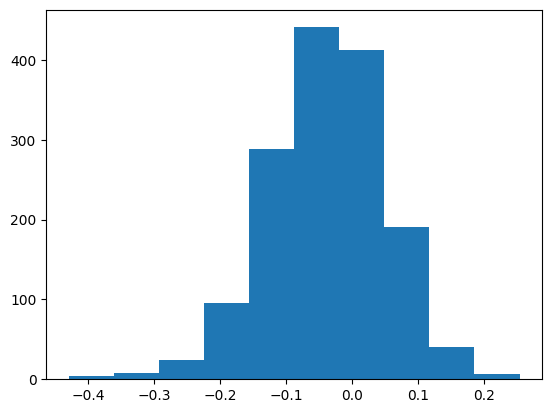

In [57]:
plt.hist(khat["KL"])